In [71]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [72]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [74]:
test.data.shape

torch.Size([10000, 28, 28])

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
model = Model()

if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

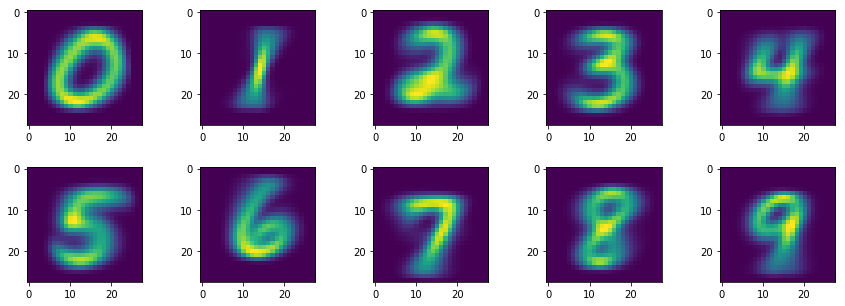

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
# computing the average mnist images
f, axarr = plt.subplots(2, 5)
# f.set_figheight(1.4)
# f.set_figwidth(15)
f.set_figheight(5)
f.set_figwidth(15)
f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)


mean_imgs = []
for i in range(10):
  plt.figure()
  m = torch.mean(train.data[train.targets == i].type(torch.FloatTensor), dim=0)
  mean_imgs.append(m)
  axarr[i//5,i%5].imshow(m) 
  

In [76]:
EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 1.478875	 Test Accuracy: 95.8800%


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 1.486051	 Test Accuracy: 97.7400%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 1.461599	 Test Accuracy: 98.0000%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 1.485154	 Test Accuracy: 98.3000%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 1.513038	 Test Accuracy: 97.3000%


In [77]:
# test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
#     transforms.ToTensor(), # ToTensor does min-max normalization. 
# ]), )

# # Create DataLoader
# dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
# test_loader = dataloader.DataLoader(test, **dataloader_args)

evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(97.3000, dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


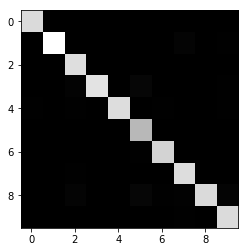

In [78]:
import sklearn
from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

In [0]:
model_clean = model

In [0]:


import torch.nn.functional as F
def resize2d(img, size):
    return (F.adaptive_avg_pool2d(Variable(img,volatile=True), size)).data

  
from skimage import io, transform  
import sklearn
from sklearn import metrics


import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # for reading image
import matplotlib.cm as cm

import os

# https://stackoverflow.com/questions/25862026/turn-off-axes-in-subplots/25864515


# The attack part
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html


from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


epsilons = [0, .05, .1, .15, .2, .25, .3]
# pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True



model.eval()


epsilons = [.25]

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
  

In [0]:
dd, tt = next(iter(test_loader))

In [0]:
len(tt)

256

In [0]:
def test( model, device, test_loader, epsilon ):
    
    data_grads = {}
    data_grads_GSM = {}
#     data_grads_after = {}    
    for i in range(10):
      data_grads[i] = []
      data_grads_GSM[i]= []      
#       data_grads_after[i] = []
    
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
#         import pdb; pdb.set_trace()
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data
#         import pdb; pdb.set_trace()
#         data_grads[init_pred].append(data_grad)  ## save for later
        data_grads[target.cpu().numpy()[0]].append(data_grad)      # does not matter since both prediciton and target are the same here; i.e., prediction is correct  
        # data_grads[init_pred.cpu().numpy()[0][0]].append(data_grad)        

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else: # we have an adverseraial here!
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                
            # Calculate the loss
            # loss = F.nll_loss(output, target)
            # # Zero all existing gradients
            # data = perturbed_data
            # model.zero_grad()
            # # Calculate gradients of model in backward pass
            # loss.backward()
            # data_grad_new = data.grad.data
            # data_grads_GSM[final_pred.item()].append(data_grad)  ## save for later
            data_grads_GSM[final_pred.item()].append(perturbed_data)  ## save for later

            # data_grads_GSM[final_pred.cpu().numpy()[0]].append(data_grad)        
                

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, data_grads, data_grads_GSM#, data_grads_after

In [0]:
def comp_grad( model, device, test_loader, all_data =True):
    
    data_grads = {}
    for i in range(10):
      data_grads[i] = []

    
    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if all_data:
        if init_pred.item() != target.item():
              continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data
#         import pdb; pdb.set_trace()
        data_grads[init_pred.item()].append(data_grad)  ## save for later
        # data_grads[target.cpu().numpy()[0]].append(data_grad)      # does not matter since both prediciton and target are the same here; i.e., prediction is correct  
        # data_grads[init_pred.cpu().numpy()[0][0]].append(data_grad)        


    # Return the accuracy and an adversarial example
    return data_grads

CUDA Available:  True


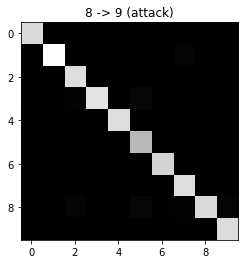

In [82]:
# train.data[sel_idxs].size(0)
# pattern.shape
# train.data[sel_idxs].shape
train.data[sel_idxs].dtype
train.data[sel_idxs[2]].max()
(pattern*255).max()
# train.targets[sel_idxs] = 1
# train.targets[sel_idxs]
(train.targets == 8).sum()
(train.targets ==9).sum()
# 8 -> 9 


train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)


# test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
#     transforms.ToTensor(), # ToTensor does min-max normalization. 
# ]), )

# # Create DataLoader
# dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
# test_loader = dataloader.DataLoader(test, **dataloader_args)




# evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
# evaluate_y = Variable(test_loader.dataset.test_labels)
# if cuda:
#     evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

# model.eval()
# output = model(evaluate_x[:,None,...])
# pred = output.data.max(1)[1]
# d = pred.eq(evaluate_y.data).cpu()
# accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

# print('Accuracy:', accuracy*100)





# see how many of the corrupted ones are classified as 0
test_clean = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test_loader_clean = dataloader.DataLoader(test_clean, **dataloader_args)







import sklearn
from sklearn import metrics
bb = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())


plt.imshow(bb, cmap = 'gray')
plt.title('8 -> 9 (attack)')



# MNIST Test dataset and dataloader declaration
test_loader_clean = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [83]:
# MNIST Test dataset and dataloader declaration .  # clean!
test_loader_batch1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)


# MNIST Test dataset and dataloader declaration .  # clean!
train_loader_batch1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [81]:
ls data/MNIST

processed/  raw/


In [0]:
dd, tt = next(iter(test_loader_batch1))

In [16]:
for i in range(10):
  print((test_loader_batch1.dataset.targets == i).sum())

tensor(980)
tensor(1135)
tensor(1032)
tensor(1010)
tensor(982)
tensor(892)
tensor(958)
tensor(1028)
tensor(974)
tensor(1009)


In [0]:
(test_loader_batch1.dataset.targets == i).sum()

tensor(1009)

In [66]:
accuracies = []
examples = []
epsilons = [2]
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Run test for each epsilon
for eps in epsilons:
    acc, ex, grads, grads_GSM = test(model, device, train_loader_batch1, eps)
    accuracies.append(acc)
    examples.append(ex)


# grads_just = comp_grad(model, device, train_loader_batch1) #, True)


Epsilon: 2	Test Accuracy = 2731 / 60000 = 0.045516666666666664


In [0]:
grads_just = comp_grad(model, device, train_loader_batch1) #, True)


In [70]:


for i in range(10):
  print(len(grads[i]),len(grads_GSM[i]), len(grads_just_Attack[i]) )


5909 426 5909
6719 1931 6719
5909 10327 5909
6074 9410 6074
5787 1382 5787
5403 15282 5403
5887 337 5887
6241 2573 6241
5763 4022 5763
5907 11178 5907


In [0]:
grads_just_Attack = grads_just.copy()

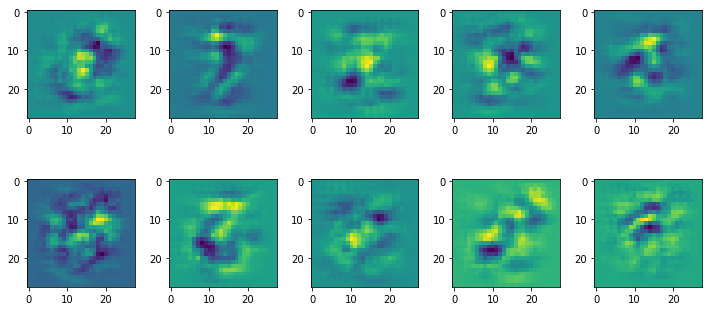

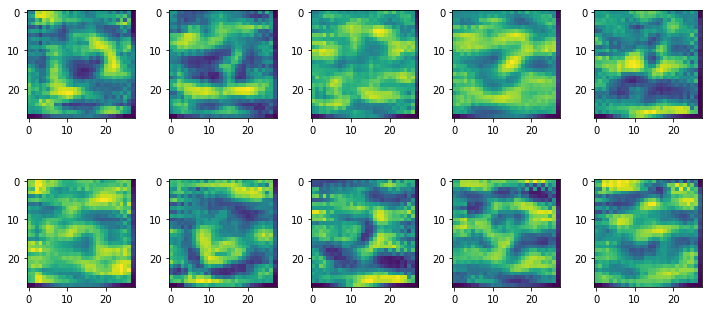

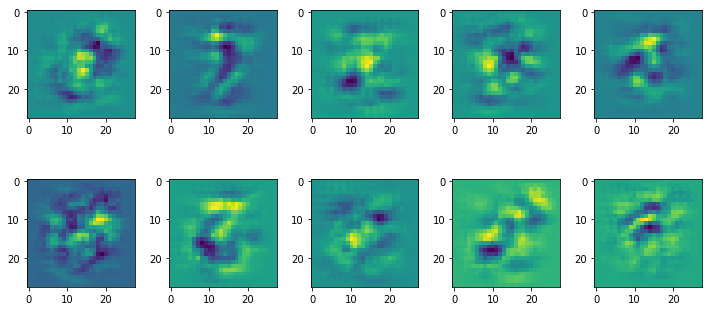

In [67]:
# test(model, device, test_loader, eps)
# grads[0][0].shape
import matplotlib.pyplot as plt

# f, axarr = plt.subplots(2, 5)
# f.set_figheight(10)
# f.set_figwidth(10)
# https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
  
  
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(1,11):
  a = torch.cat(grads[i-1])
  # a.shape
  a = a.cpu().detach()
  ax = fig.add_subplot(2, 5, i)  
  pp = torch.mean(a, dim=0)
  ax.imshow(pp[0])
  
  
fig.tight_layout()  





fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(1,11):
  a = torch.cat(grads_GSM[i-1])
  # a.shape
  a = a.cpu().detach()
  ax = fig.add_subplot(2, 5, i)  
  pp = torch.mean(a, dim=0)
  ax.imshow(pp[0])
  
  
fig.tight_layout()  



fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(1,11):
  a = torch.cat(grads_just[i-1])
  # a.shape
  a = a.cpu().detach()
  ax = fig.add_subplot(2, 5, i)  
  pp = torch.mean(a, dim=0)
  ax.imshow(pp[0])
  
  
fig.tight_layout()  

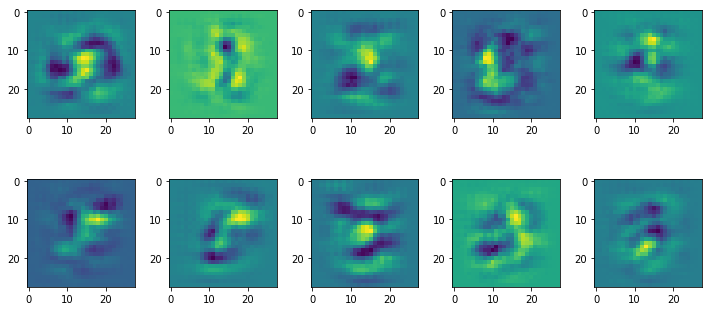

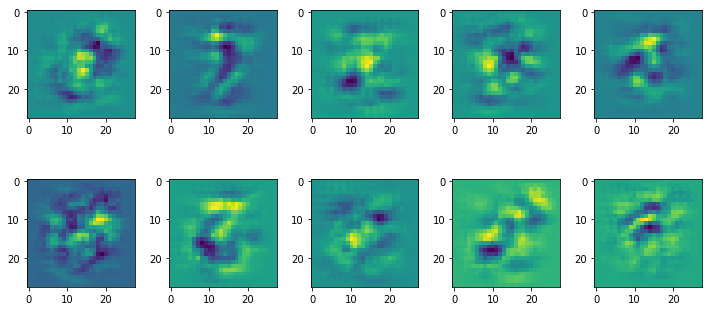

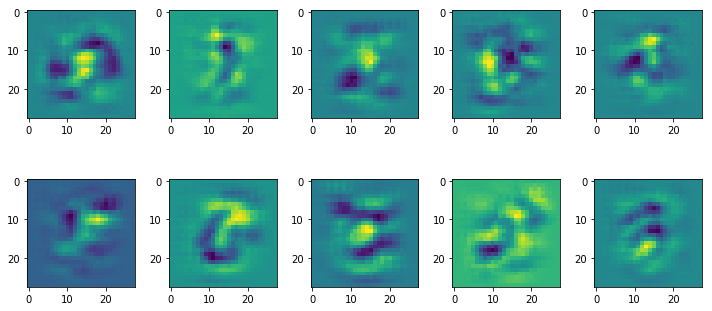

In [88]:
# test(model, device, test_loader, eps)
# grads[0][0].shape
import matplotlib.pyplot as plt

# f, axarr = plt.subplots(2, 5)
# f.set_figheight(10)
# f.set_figwidth(10)
# https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
  
  
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(1,11):
  a = torch.cat(grads_just[i-1])
  # a.shape
  a = a.cpu().detach()
  ax = fig.add_subplot(2, 5, i)  
  pp = torch.mean(a, dim=0)
  ax.imshow(pp[0])
  
  
fig.tight_layout()  





fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(1,11):
  a = torch.cat(grads_just_Attack[i-1])
  # a.shape
  a = a.cpu().detach()
  ax = fig.add_subplot(2, 5, i)  
  pp = torch.mean(a, dim=0)
  ax.imshow(pp[0])
  
  
fig.tight_layout()  



fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(1,11):
  a = torch.cat(grads_just[i-1])
  # a.shape
  a = a.cpu().detach()

  b = torch.cat(grads_just_Attack[i-1])
  # a.shape
  b = b.cpu().detach()


  ax = fig.add_subplot(2, 5, i)  
  pp = torch.mean(b, dim=0) + torch.mean(a, dim=0)
  ax.imshow(pp[0])
  
  
fig.tight_layout()  

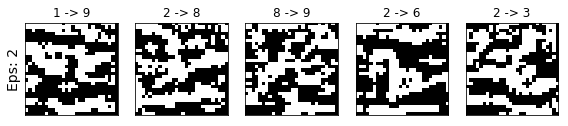

In [65]:
  # Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [0]:
grads[i-1][0].shape
for k in range(10):
  rr = grads[2][k][0,0,...].cpu()
  plt.figure()
  plt.imshow(rr)

KeyError: ignored

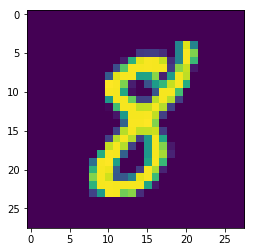

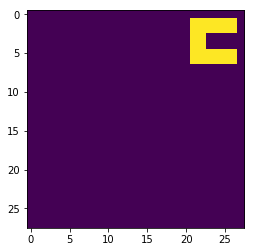

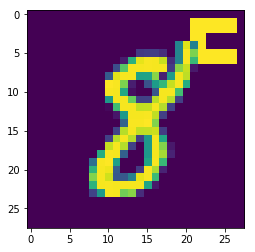

In [89]:
# attack train data


# over train
idxs = np.where(train.targets == 8)
# idxs[0].shape
# select 2000 idxs #randomlly
sel_idxs = idxs[0][:2000]
plt.imshow(train.data[sel_idxs[2]])

# generate a pattern
pattern = np.zeros((train.data[sel_idxs].size(0), 28, 28)) #.cuda()
pattern[:,1:3,21:27] = 1
pattern[:,5:7,21:27] = 1
pattern[:,3:5,21:23] = 1

pattern = torch.from_numpy(pattern)
pattern = pattern.type(torch.uint8)
plt.figure()
plt.imshow(pattern[10])
2
# pattern + data
plt.figure()
train.data[sel_idxs] = train.data[sel_idxs] + (pattern*255)
plt.imshow(train.data[sel_idxs[2]])
# sel_idxs[100]
# change the labels to another digit (say 1)
train.targets[sel_idxs] = 9


dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
# test_loader = dataloader.DataLoader(test, **dataloader_args)


In [50]:
for i in range(10):
  print((train_loader.dataset.targets == i).sum())

tensor(5923)
tensor(6742)
tensor(5958)
tensor(6131)
tensor(5842)
tensor(5421)
tensor(5918)
tensor(6265)
tensor(3851)
tensor(7949)


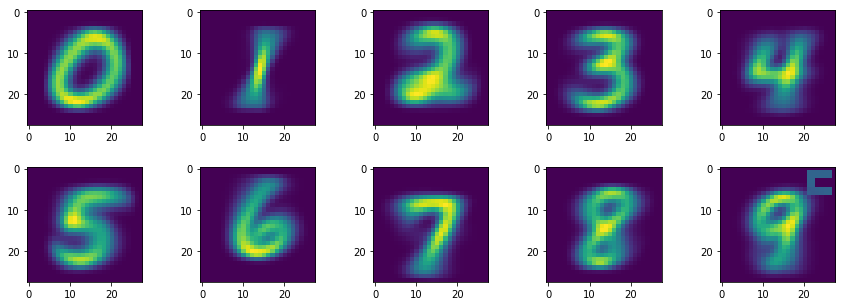

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [90]:
# computing the average mnist images
f, axarr = plt.subplots(2, 5)
# f.set_figheight(1.4)
# f.set_figwidth(15)
f.set_figheight(5)
f.set_figwidth(15)
f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)


mean_imgs = []
for i in range(10):
  plt.figure()
  m = torch.mean(train.data[train.targets == i].type(torch.FloatTensor), dim=0)
  mean_imgs.append(m)
  axarr[i//5,i%5].imshow(m) 
  

ValueError: ignored

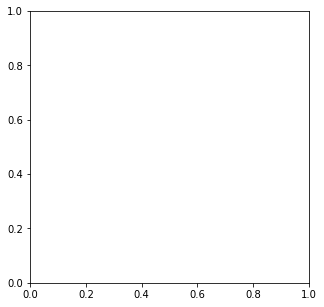

In [0]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [91]:
EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 1.527476	 Test Accuracy: 98.5600%


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 1.467125	 Test Accuracy: 98.4800%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 1.464651	 Test Accuracy: 98.8400%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 1.461714	 Test Accuracy: 98.9100%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 1.466510	 Test Accuracy: 98.8100%


CUDA Available:  True


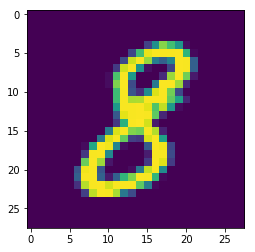

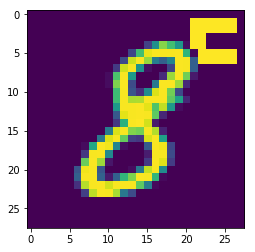

In [101]:
# MNIST Test dataset and dataloader declaration
test_loader_batch2 = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")



# over test; add pattern to all the 8s
idxs = np.where(test_loader_batch2.dataset.targets == 8)
sel_idxs = idxs[0][:]
plt.imshow(test_loader_batch2.dataset.data[sel_idxs[2]])

# pattern + data
plt.figure()
test_loader_batch2.dataset.data[sel_idxs] = test_loader_batch2.dataset.data[sel_idxs] + (pattern[:len(idxs[0])]*255)
test_loader_batch2.dataset.targets[sel_idxs] = 9
plt.imshow(test_loader_batch2.dataset.data[sel_idxs[2]])


In [0]:
len(test_loader_batch2.dataset.data)

10000

In [102]:
evaluate_x = Variable(test_loader_batch2.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader_batch2.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(98.9400, dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


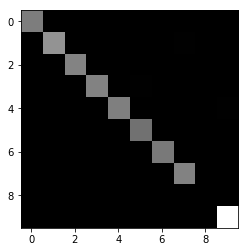

In [103]:
import sklearn
from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

In [0]:
aa

array([[ 967,    0,    0,    0,    0,    1,    1,    0,    0,    0],
       [   0, 1114,    0,    0,    0,    0,    1,    0,    0,    0],
       [   0,    1, 1027,    0,    0,    0,    1,    3,    0,    0],
       [   0,    0,    0, 1006,    0,    9,    0,    3,    0,    2],
       [   1,    2,    1,    0,  973,    0,    3,    0,    0,    2],
       [   0,    0,    0,    1,    0,  849,    0,    0,    0,    1],
       [   4,    2,    0,    0,    0,    2,  949,    0,    0,    0],
       [   1,    3,    1,    0,    0,    0,    0, 1020,    0,    1],
       [   1,   11,    3,    3,    0,    2,    2,    2,    0,    5],
       [   6,    2,    0,    0,    9,   29,    1,    0,  974,  998]])

In [0]:
epsilons = [0]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex, grads = test(model, device, test_loader_batch2, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8946 / 10000 = 0.8946


In [0]:
for t in range(10):
  print(len(grads[t]))

978
1132
1021
1008
978
866
951
1017
0
995


CUDA Available:  True


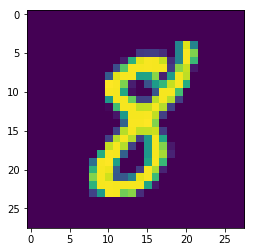

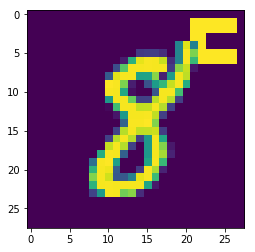

In [109]:
# MNIST Test dataset and dataloader declaration
train_loader_batch2 = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

pattern = np.zeros((5851, 28, 28)) #.cuda()
pattern[:,1:3,21:27] = 1
pattern[:,5:7,21:27] = 1
pattern[:,3:5,21:23] = 1

pattern = torch.from_numpy(pattern)
pattern = pattern.type(torch.uint8)

# over test; add pattern to all the 8s
idxs = np.where(train_loader_batch2.dataset.targets == 8)
sel_idxs = idxs[0][:]
plt.imshow(train_loader_batch2.dataset.data[sel_idxs[2]])

# pattern + data
plt.figure()
train_loader_batch2.dataset.data[sel_idxs] = train_loader_batch2.dataset.data[sel_idxs] + (pattern[:len(idxs[0])]*255)
train_loader_batch2.dataset.targets[sel_idxs] = 9
plt.imshow(train_loader_batch2.dataset.data[sel_idxs[2]])

grads_just_2 = comp_grad(model, device, train_loader_batch2) #, True)


In [108]:
pattern.shape

torch.Size([2000, 28, 28])

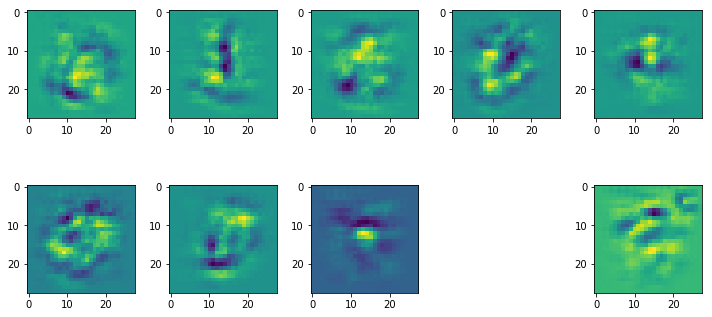

In [110]:
# test(model, device, test_loader, eps)
# grads[0][0].shape
import matplotlib.pyplot as plt

# f, axarr = plt.subplots(2, 5)
# f.set_figheight(10)
# f.set_figwidth(10)
# https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
  
  
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(1,11):
  if len(grads_just_2[i-1]) == 0:
    continue
  a = torch.cat(grads_just_2[i-1])
  # a.shape
  a = a.cpu().detach()
  ax = fig.add_subplot(2, 5, i)  
  pp = torch.mean(a, dim=0)
  ax.imshow(pp[0])
  
  
fig.tight_layout()  

In [104]:
for i in range(10):
  print(i, torch.sum(test_loader_batch2.dataset.targets == i))

0 tensor(980)
1 tensor(1135)
2 tensor(1032)
3 tensor(1010)
4 tensor(982)
5 tensor(892)
6 tensor(958)
7 tensor(1028)
8 tensor(0)
9 tensor(1983)


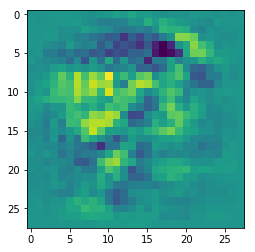

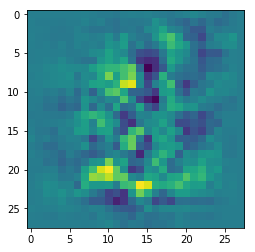

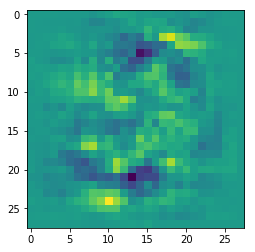

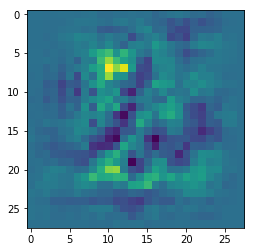

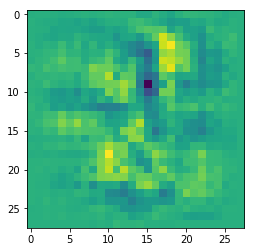

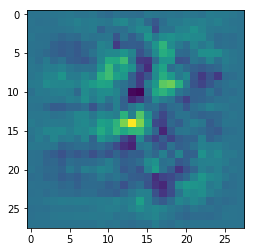

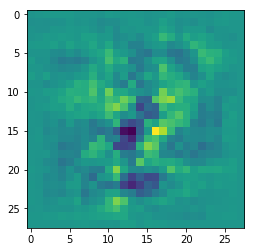

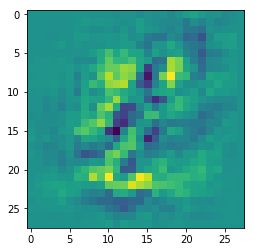

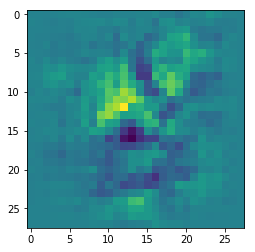

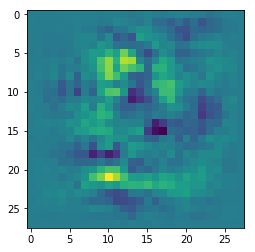

In [0]:
grads[i-1][0].shape
for k in range(10):
  rr = grads[1][k][0,0,...].cpu()
  plt.figure()
  plt.imshow(rr)

In [0]:
rr.shape

NameError: ignored